In [24]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns

api = wandb.Api()


In [25]:
flickr_mlp=api.run("luisawerner/nesy23/39y1lkxu").summary['test_accuracies']
flickr_kenn_mlp=api.run("luisawerner/nesy23/18bmvs3p").summary['test_accuracies']
flickr_gcn=api.run("luisawerner/nesy23/2yg139x5").summary['test_accuracies']
flickr_kenn_gcn=api.run("luisawerner/nesy23/2a90jqbn").summary['test_accuracies']
flickr_kenn_gat = api.run("luisawerner/nesy23/3kegoy97").summary['test_accuracies'][:10]
flickr_gat = api.run("luisawerner/nesy23/1njo5u0k").summary['test_accuracies']

import torch_geometric.datasets
[flickr_dataset] = getattr(torch_geometric.datasets, 'Flickr')(root='Flickr')
num_classes = 7
color = plt.cm.rainbow(np.linspace(0, 1, num_classes))

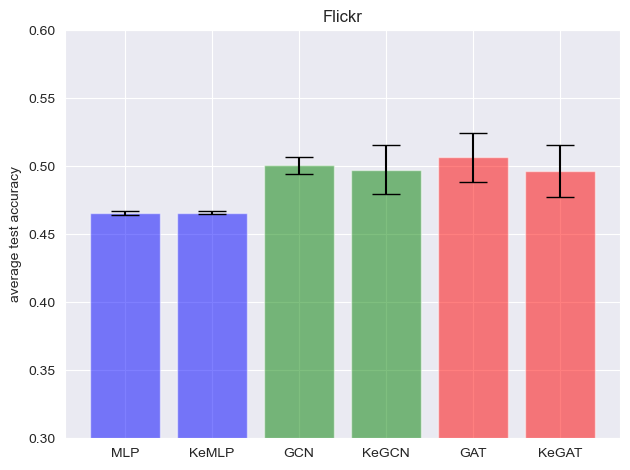

Mean Average Test Accuracy over 10 runs: 
MLP: 0.465634383543226 (0.0017608032302256005), KeMLP: 0.46592569354188146 (0.0013005867928203446)
GCN: 0.5007036256890601 (0.006364154539571432), KeGCN: 0.4974409537041186 (0.017933179062878835)
GAT: 0.5065432707390312 (0.018230246764286733), KeGAT: 0.4965625420158652 (0.01933974386180542)


p-value KeMLP > MLP for Flickr: 0.34721129645060733
p-value KeGCN > GCN for Flickr: 0.6933761050409264
p-value KeGAT > GAT for Flickr: 0.8626453166396265
p-value KeGAT > KeMLP for Flickr: 8.143883055599075e-05
p-value GCN > KeMLP for Flickr: 2.040930829165464e-12
p-value GAT > KeMLP for Flickr: 1.479967332662151e-06


In [26]:
# PubMed
color_h=['blue', 'blue', 'green', 'green', 'red', 'red']

xpos = np.arange(6)
flickr_means = [np.mean(flickr_mlp), np.mean(flickr_kenn_mlp), np.mean(flickr_gcn), np.mean(flickr_kenn_gcn), np.mean(flickr_gat), np.mean(flickr_kenn_gat)]
flickr_errors = [np.std(flickr_mlp), np.std(flickr_kenn_mlp), np.std(flickr_gcn), np.std(flickr_kenn_gcn), np.std(flickr_gat), np.std(flickr_kenn_gat)]
fig, ax = plt.subplots()
ax.bar(xpos, flickr_means, yerr=flickr_errors, align='center', alpha=0.5, ecolor='black', capsize=10, color=color_h)
ax.set_ylabel('average test accuracy')
ax.set_xticks(xpos)
ax.set_xticklabels(['MLP', 'KeMLP', 'GCN', 'KeGCN', 'GAT', 'KeGAT'])
ax.set_title('Flickr')
ax.yaxis.grid(True)

# Save the figure and show
plt.ylim(0.3, 0.6)
plt.tight_layout()
plt.savefig('figures/results_flickr.pdf', format='pdf')
plt.show()
print(f'Mean Average Test Accuracy over {len(flickr_mlp)} runs: ')
print(f'MLP: {np.mean(flickr_mlp)} ({np.std(flickr_mlp)}), KeMLP: {np.mean(flickr_kenn_mlp)} ({np.std(flickr_kenn_mlp)})' )
print(f'GCN: {np.mean(flickr_gcn)} ({np.std(flickr_gcn)}), KeGCN: {np.mean(flickr_kenn_gcn)} ({np.std(flickr_kenn_gcn)})' )
print(f'GAT: {np.mean(flickr_gat)} ({np.std(flickr_gat)}), KeGAT: {np.mean(flickr_kenn_gat)} ({np.std(flickr_kenn_gat)})' )
print ('\n')

print(f'p-value KeMLP > MLP for Flickr: {scipy.stats.ttest_ind(flickr_kenn_mlp, flickr_mlp, alternative="greater")[1]}')
print(f'p-value KeGCN > GCN for Flickr: {scipy.stats.ttest_ind(flickr_kenn_gcn, flickr_gcn, alternative="greater")[1]}')
print(f'p-value KeGAT > GAT for Flickr: {scipy.stats.ttest_ind(flickr_kenn_gat, flickr_gat, alternative="greater")[1]}')
print(f'p-value KeGAT > KeMLP for Flickr: {scipy.stats.ttest_ind(flickr_kenn_gat, flickr_kenn_mlp, alternative="greater")[1]}')
print(f'p-value GCN > KeMLP for Flickr: {scipy.stats.ttest_ind(flickr_gcn, flickr_kenn_mlp, alternative="greater")[1]}')
print(f'p-value GAT > KeMLP for Flickr: {scipy.stats.ttest_ind(flickr_gat, flickr_kenn_mlp, alternative="greater")[1]}')



In [27]:
import numpy as np
def compute_compliance(data, num_classes):
    """
    compute clause compliance per iteration
    returns a list of length |number classes| with compliance value per each
    """
    # y = model.data.y.cpu().detach().numpy() do we need to detach or is this even slowing down the code?
    y = data.y.numpy()
    edge_index = np.transpose(data.edge_index.numpy())
    train_mask = data.train_mask.numpy()
    train_edge_mask = np.logical_or(train_mask[edge_index[:, 0]], train_mask[edge_index[:, 1]])

    # calculate the classes corresponding to edge index
    edge_index_cls = np.zeros_like(edge_index)
    for row in range(edge_index.shape[0]):
        edge_index_cls[row, 0] = y[edge_index[row, 0]]
        edge_index_cls[row, 1] = y[edge_index[row, 1]]

    compliance = []
    for cls in range(num_classes):
        cls_mask = np.logical_or(edge_index_cls[:, 0] == cls, edge_index_cls[:, 1] == cls)
        mask = np.logical_and(cls_mask, train_edge_mask) # edges that have at least a training node and a node of class cls
        same_mask = np.logical_and(mask, np.equal(edge_index_cls[:, 0], edge_index_cls[:, 1])) # edges that are of the above set and have the same class for both nodes
        cls_compliance = sum(same_mask)/sum(mask)
        compliance.append(cls_compliance)

    return compliance

In [28]:
print(f'Compliance Cora: {compute_compliance(flickr_dataset, num_classes=num_classes)}')

Compliance Cora: [0.04393460436629458, 0.1334592655494515, 0.0741020871236125, 0.04512233049968899, 0.2411165573874849, 0.0328884652049571, 0.2782410646348999]


In [29]:

num_runs = 10
# for Cora
flickr_KeMLP=eval(api.run("luisawerner/nesy23/18bmvs3p").summary['logged_clause_weights'])
flickr_KeGCN=eval(api.run("luisawerner/nesy23/2a90jqbn").summary['logged_clause_weights'])
flickr_KeGAT=eval(api.run("luisawerner/nesy23/3kegoy97").summary['logged_clause_weights'])


In [30]:
# KeMLP
num_layers = 1
# print clause weights of last epoch
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [flickr_KeMLP[i][layer][str(cls)][-1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.08416696563363076, std clause weight: 0.025498025036743047
Class 1, Layer 0: Mean clause weight 0.08648650199174882, std clause weight: 0.020292683166806044
Class 2, Layer 0: Mean clause weight 0.006747172959148884, std clause weight: 0.014461591678927601
Class 3, Layer 0: Mean clause weight 0.06981076896190644, std clause weight: 0.020949639320779635
Class 4, Layer 0: Mean clause weight 0.10639388263225555, std clause weight: 0.024547573361854088
Class 5, Layer 0: Mean clause weight 0.0718598997220397, std clause weight: 0.035465563270597536
Class 6, Layer 0: Mean clause weight 0.0779856625944376, std clause weight: 0.011851877349998308


In [31]:
#KeGCN
num_layers=4
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [flickr_KeGCN[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.0016999997198581696, std clause weight: 0.005099999159574508
Class 0, Layer 1: Mean clause weight 0.0016999997198581696, std clause weight: 0.005099999159574508
Class 0, Layer 2: Mean clause weight 0.0016999997198581696, std clause weight: 0.005099999159574508
Class 0, Layer 3: Mean clause weight 0.0016999999061226845, std clause weight: 0.0050999997183680534
Class 1, Layer 0: Mean clause weight 0.0016999928280711173, std clause weight: 0.005099978484213352
Class 1, Layer 1: Mean clause weight 0.0, std clause weight: 0.0
Class 1, Layer 2: Mean clause weight 0.0, std clause weight: 0.0
Class 1, Layer 3: Mean clause weight 0.0, std clause weight: 0.0
Class 2, Layer 0: Mean clause weight 0.0, std clause weight: 0.0
Class 2, Layer 1: Mean clause weight 0.0, std clause weight: 0.0
Class 2, Layer 2: Mean clause weight 0.0, std clause weight: 0.0
Class 2, Layer 3: Mean clause weight 0.0, std clause weight: 0.0
Class 3, Layer 0: Mean clause weight 0.00339

In [32]:
#KeGAT
num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [flickr_KeGAT[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.0354543105699122, std clause weight: 0.02254563463724952
Class 1, Layer 0: Mean clause weight 0.04477888122200966, std clause weight: 0.013565438787594907
Class 2, Layer 0: Mean clause weight 0.04050593813881278, std clause weight: 0.015349312769502398
Class 3, Layer 0: Mean clause weight 0.040953335259109734, std clause weight: 0.018164503731584274
Class 4, Layer 0: Mean clause weight 0.07558466009795665, std clause weight: 0.030182102506704868
Class 5, Layer 0: Mean clause weight 0.05161256026476622, std clause weight: 0.050689986392109546
Class 6, Layer 0: Mean clause weight 0.07001331672072411, std clause weight: 0.019884313632858877


Class 0, Layer 0: Mean of learned clause weight over runs: 0.08416696563363076, std clause weight: 0.025498025036743047
Class 1, Layer 0: Mean of learned clause weight over runs: 0.08648650199174882, std clause weight: 0.020292683166806044
Class 2, Layer 0: Mean of learned clause weight over runs: 0.006747172959148884, std clause weight: 0.014461591678927601
Class 3, Layer 0: Mean of learned clause weight over runs: 0.06981076896190644, std clause weight: 0.020949639320779635
Class 4, Layer 0: Mean of learned clause weight over runs: 0.10639388263225555, std clause weight: 0.024547573361854088
Class 5, Layer 0: Mean of learned clause weight over runs: 0.0718598997220397, std clause weight: 0.035465563270597536
Class 6, Layer 0: Mean of learned clause weight over runs: 0.0779856625944376, std clause weight: 0.011851877349998308
Citeseer Compliance: [0.04393460436629458, 0.1334592655494515, 0.0741020871236125, 0.04512233049968899, 0.2411165573874849, 0.0328884652049571, 0.278241064634899

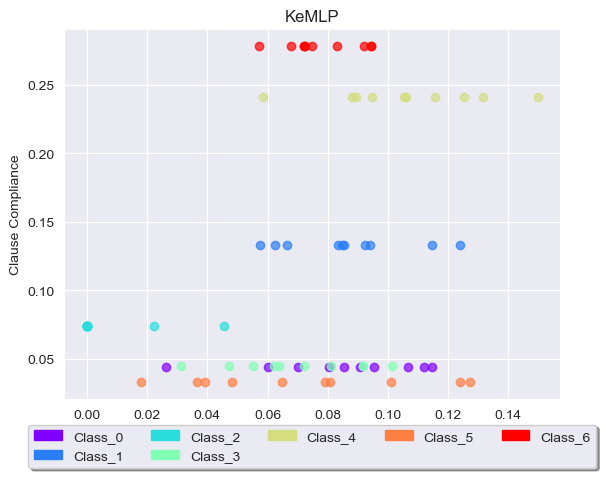

In [35]:
# KeMLP

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns
color = plt.cm.rainbow(np.linspace(0, 1, num_classes))

num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [flickr_KeMLP[i][layer][str(cls)][-1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

flickr_compliance = compute_compliance(flickr_dataset, num_classes=num_classes)
print(f'Citeseer Compliance: {flickr_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [flickr_KeMLP[i][0][j][-1] for i in range(num_runs)]
    for i in _list:
        plt.scatter(i, flickr_compliance[k] #+ np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeMLP')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


Class 0, Layer 0: Mean of learned clause weight over runs: 0.002767750062048435, std clause weight: 0.008303250186145306
Class 0, Layer 1: Mean of learned clause weight over runs: 0.0027171943336725237, std clause weight: 0.00815158300101757
Class 0, Layer 2: Mean of learned clause weight over runs: 0.0026730498299002647, std clause weight: 0.008019149489700794
Class 0, Layer 3: Mean of learned clause weight over runs: 0.0026332974433898927, std clause weight: 0.007899892330169677
Class 1, Layer 0: Mean of learned clause weight over runs: 0.0, std clause weight: 0.0
Class 1, Layer 1: Mean of learned clause weight over runs: 0.003016384318470955, std clause weight: 0.009049152955412865
Class 1, Layer 2: Mean of learned clause weight over runs: 0.00502540310844779, std clause weight: 0.010421517057713636
Class 1, Layer 3: Mean of learned clause weight over runs: 0.009069519845070317, std clause weight: 0.014110050713741062
Class 2, Layer 0: Mean of learned clause weight over runs: 0.0054

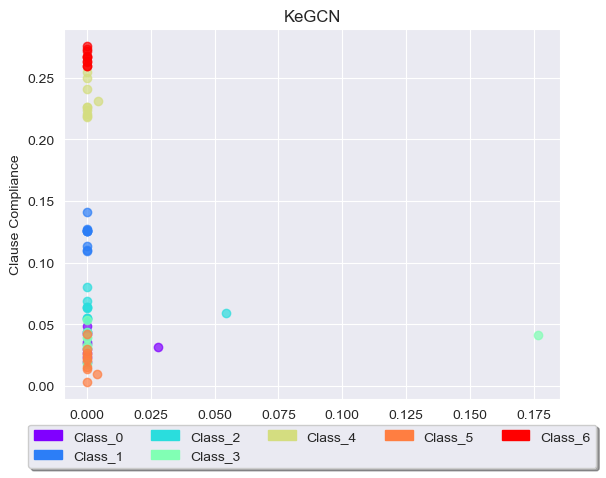

In [37]:
# KeMLP

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns
color = plt.cm.rainbow(np.linspace(0, 1, num_classes))

num_layers=4
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [flickr_KeGCN[i][layer][str(cls)][-1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

flickr_compliance = compute_compliance(flickr_dataset, num_classes=num_classes)
print(f'Citeseer Compliance: {flickr_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [flickr_KeGCN[i][0][j][-1] for i in range(num_runs)]
    for i in _list:
        plt.scatter(i, flickr_compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeGCN')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


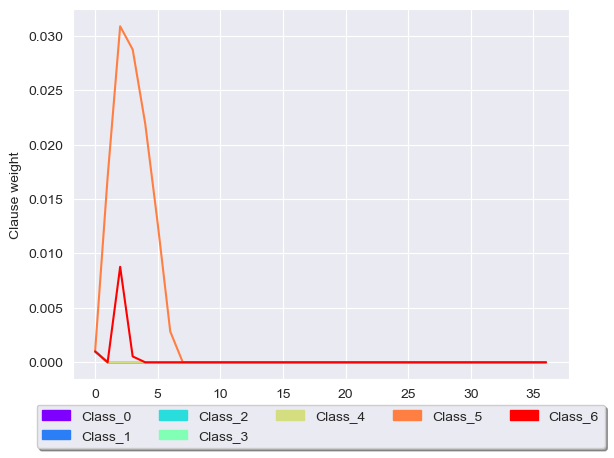

In [40]:
run = 2
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = flickr_KeGCN[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

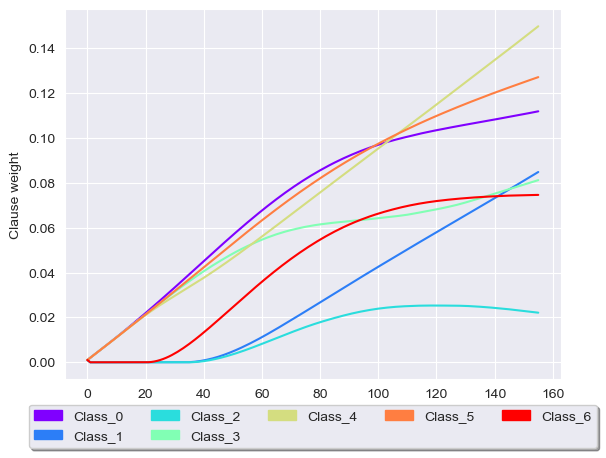

In [41]:

run = 2
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_' + j))
    _list = flickr_KeMLP[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()